# Exercise 3: Off-Policy Methods

---

> **Reinforcement Learning** in Winter Semester 2025/2026
>
> - Prof. Gerhard Neumann and Prof. Rudolf Lioutikov
> - Instructor for this exercise: Tai Hoang (tai.hoang@kit.edu)
> 
> ⚠️ For general questions about the exercises, please post in the Ilias forum so we can answer them once for all students. Only use email for individual questions whose answers are not relevant to all students.

---

# Group Submission

The exercise sheets can be submitted in groups of up to **3 students**. **Only one member in the group is required to upload the final version via Ilias**.

Groups are automatically recorded, so **please enter the u-identifiers of your group members in the following cell.** If your group consists of only 2 students, or if you are submitting alone, leave the remaining fields empty. Here is an **example** for a group consisting of uabcd and uefgh:

_U-identifiers of group members:_

_Member 1: urphy

_Member 2: ubhqg

_Member 3:_

U-identifiers of group members:

Member 1: 

Member 2:

Member 3:

# Auto-grading

We use an auto-grading system that automatically analyzes your submitted Jupyter Notebooks and checks them for correctness using hidden tests. These tests determine the points you receive for the exercise sheet.

To ensure auto-grading works smoothly, please note the following:

- The notebook must have the filename "ex_03_off_policy_methods.ipynb"
- Upload Jupyter Notebook on Ilias (not as a zip!)
- Before submitting a notebook, test that everything runs without errors from start to finish.
- Cells marked with "##### DO NOT CHANGE #####" must not be edited or deleted
- Your solution must be entered in the correct cell (marked with "# YOUR CODE HERE").
  - Please delete the **NotImplementedError!**
- Generally, **do not delete any cells** and **do not add any cells**. The cells where your solution should be entered already exist (marked with "# YOUR CODE HERE").
- There may be seemingly empty cells that are also marked with "##### DO NOT CHANGE #####". These must also not be edited or deleted.
  - If you do modify them, auto-grading will not work and you will receive no points.
  - We will be strict about this and make no exceptions if someone modifies cells clearly marked as readonly!
- The Jupyter Notebooks have inline tests (visible to you) that check your result for basic correctness.
  - These are primarily for you to identify and correct errors.
  - However, the inline tests you can see in the notebook are not the tests used for grading!
  - The inline tests are a necessary but not sufficient condition to receive points when grading the task!

## Local Setup

If you prefer to work locally, see the following instructions for setting up Python in a virtual environment.
You can then ignore the instructions in "Colab Setup".

If you haven't yet, create a [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) environment using:
```
conda create --name rl_exercises
conda activate rl_exercises
```
Torch recommends installation using conda rather than pip, so run:
```
conda install pytorch cpuonly -c pytorch
```
If you have a CUDA-enabled GPU and would like to use it, visit [the installation page](https://pytorch.org/get-started/locally/) to see the options available for different CUDA versions.
The remaining dependencies can be installed with pip:
```
pip install matplotlib numpy "gymnasium[classic-control]"
```

Even if you are running the Jupyter notebook locally, please run the code cells in **Colab Setup**, because they define some global variables required later.

## Colab Setup

Google Colab provides you with a temporary environment for python programming.
While this conveniently works on any platform and internally handles dependency issues and such, it also requires you to set up the environment from scratch every time.
The "Colab Setup" section below will be part of **every** exercise and contains utility that is needed before getting started.

There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window).
Any changes you make to the Jupyter notebook itself should be saved to your Google Drive.
We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout.
However, you will need to re-mount your Google Drive and re-install packages with every new instance.

In [1]:
##### DO NOT CHANGE #####
"""Your work will be stored in a folder called `rl_ws25` by default to prevent Colab 
instance timeouts from deleting your edits.
We do this by mounting your google drive on the virtual machine created in this colab 
session. For this, you will likely need to sign in to your Google account and allow
access to your Google Drive files.
"""

from pathlib import Path
try:
    from google.colab import drive
    drive.mount("/content/gdrive")
    COLAB = True
except ImportError:
    COLAB = False

# Create paths in your google drive
if COLAB:
    DATA_ROOT = Path("/content/gdrive/My Drive/rl_ws25")
    DATA_ROOT.mkdir(exist_ok=True)
else:
    DATA_ROOT = Path.cwd() / "rl_ws25"

# Install **python** packages
if COLAB:
    %pip install matplotlib numpy "gymnasium[classic-control]" torch

##### DO NOT CHANGE #####

# Exercise 3: Soft Actor-Critic (SAC)

In this exercise, we will implement the **Soft Actor-Critic (SAC)** algorithm. SAC is an off-policy actor-critic method that is widely used due to its sample efficiency and stability. It acts under a maximum entropy principle to ensure sufficient exploration during training.

Key features of SAC:
1. **Maximum entropy**: Encourages exploration by maximizing both reward and policy entropy
2. **Twin Q-networks**: Uses two Q-networks to reduce overestimation bias
3. **Polyak updates**: Soft target network updates for stability
4. **Off-policy**: Learns from a replay buffer for sample efficiency

We will test SAC on the [Pendulum-v1](https://gymnasium.farama.org/environments/classic_control/pendulum/) environment.

We start by importing all the necessary python modules and defining some helper functions which you do not need to change.

In [2]:
##### DO NOT CHANGE #####
%matplotlib inline

import time
import copy
import random
import collections
from typing import Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import gymnasium as gym

SEED = 42

# specify the path to save the recordings of this run to.
DATA_PATH = DATA_ROOT / "exercise_3" / time.strftime("%Y-%m-%d_%H-%M")

def save_figure(fig: plt.Figure, save_name: str) -> None:
    """Saves a figure into your google drive folder or local directory"""
    DATA_PATH.mkdir(parents=True, exist_ok=True)
    path = DATA_PATH / (save_name + ".png")
    # DO NOT CHANGE: Turn off save_figure
    # fig.savefig(str(path))

# Set seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

##### DO NOT CHANGE #####

## Pendulum Environment

The goal is to swing up a pendulum and keep it upright.

- **State**: ($\cos(\theta)$, $\sin(\theta)$, $\dot{\theta}$) - 3D continuous
- **Action**: torque in $[-2, 2]$ - 1D continuous  
- **Reward**: Negative reward based on angle and velocity (higher is better, $\max R \approx 0$)

In [3]:
##### DO NOT CHANGE #####
# Create environment
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_max = float(env.action_space.high[0])

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"Action range: [{-action_max}, {action_max}]")

##### DO NOT CHANGE #####

State dimension: 3
Action dimension: 1
Action range: [-2.0, 2.0]


## Replay Buffer

Off-policy methods use a replay buffer to store and reuse past experiences. This breaks correlation between consecutive samples and improves sample efficiency.

In [4]:
##### DO NOT CHANGE #####
class ReplayBuffer:
    def __init__(self, buffer_limit: int, batch_size: int):
        self.batch_size = batch_size
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition: tuple) -> None:
        self.buffer.append(transition)

    def sample(self) -> tuple:
        mini_batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []

        for transition in mini_batch:
            state, action, reward, next_state, done = transition
            states.append(state)
            actions.append([action])
            rewards.append([reward])
            next_states.append(next_state)
            dones.append([float(done)])

        return torch.tensor(states, dtype=torch.float), \
               torch.tensor(actions, dtype=torch.float), \
               torch.tensor(rewards, dtype=torch.float), \
               torch.tensor(next_states, dtype=torch.float), \
               torch.tensor(dones, dtype=torch.float)

    def size(self) -> int:
        return len(self.buffer)

##### DO NOT CHANGE #####

## **TASK 1: Actor/Policy network** (4 Points)

Next, we will set up the actor/policy.

### Task 1.1: Tanh Squashing
The original SAC implementation squashes its actions into the $[-1, 1]$ range using a *tanh* activation.
To ensure proper probabilities for these actions, it also squashes the log probabilities of each action accordingly.
You can show using the change of variables theorem that

\begin{align}
    \log \pi(\boldsymbol{a}|\boldsymbol{s}) = \log \mu(\boldsymbol{u}|\boldsymbol{s})-\sum_{i=1}^D \log\left(1-\tanh^2(u_i)\right)
\end{align}

for (squashed) actions $\boldsymbol{a}$, states $\boldsymbol{s}$, proposed (unsquashed) actions $\boldsymbol{u}$ and a policy
distribution $\mu$ (which you shouldn't confuse with the mean, which is sometimes also called $\mu$...)
In our case, the dimensionality $D=1$.
You will need to squash the action itself, as well as its log probability.

### Task 1.2: Training from 2 Q-Networks
As SAC is using Twin-Delayed Q-Networks to prevent the overestimation bias in the Q-Values,
the actor/policy needs to choose the minimum of both available Q-Networks for its loss function.
For this, you will need to evaluate the action using both Q-Networks, and then simply choose their minimum.

In [5]:
class PolicyNet(nn.Module):
    def __init__(self, learning_rate: float, entropy_alpha: float):
        super(PolicyNet, self).__init__()
        
        self.fc1 = nn.Linear(3, 128)
        self.mean = nn.Linear(128, 1)
        self.std = nn.Linear(128, 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.entropy_alpha = entropy_alpha
    
    def forward(self, state: torch.Tensor, deterministic: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.fc1(state))
        mean = self.mean(x)
        std = F.softplus(self.std(x))
        
        dist = Normal(mean, std)
        
        if deterministic:
            action = mean
        else:
            action = dist.rsample()
        
        log_prob = dist.log_prob(action)
        
        # Hint: Apply tanh squashing and adjust log probabilities
        # YOUR CODE HERE
        real_action = torch.tanh(action)
        real_log_prob = log_prob - torch.log(1 - real_action**2)        
        
        return real_action, real_log_prob
    
    def _compute_loss(self, q_net_1, q_net_2, states: torch.Tensor, actions: torch.Tensor, log_probs: torch.Tensor) -> torch.Tensor:
        """Helper function to compute the policy loss."""
        # YOUR CODE HERE
        q1 = q_net_1.forward(states,actions)
        q2 = q_net_2.forward(states,actions)
        min_q = torch.minimum(q1,q2)
        
        entropy = -self.entropy_alpha * log_probs
        loss = -(min_q + entropy).mean()
        return loss, entropy, min_q
    
    def train_step(self, q_net_1, q_net_2, mini_batch: tuple) -> Dict[str, float]:
        states, _, _, _, _ = mini_batch
        actions, log_probs = self.forward(states)
                
        loss, entropy, _ = self._compute_loss(q_net_1, q_net_2, states, actions, log_probs)
        
        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()        
        return {"policy_loss": loss.item(), "entropy": entropy.mean().item()}
        

In [6]:
##### DO NOT CHANGE #####
# ID: cell-16be421b326b17db - possible points: 4

# Test PolicyNet
print("Testing PolicyNet...")
test_policy = PolicyNet(learning_rate=3e-4, entropy_alpha=0.2)
test_state = torch.randn(32, 3)
test_action, test_log_prob = test_policy(test_state)

assert test_action.shape == (32, 1), "Action shape should be (batch_size, 1)"
assert test_log_prob.shape == (32, 1), "Log prob shape should be (batch_size, 1)"
assert torch.all(test_action >= -1) and torch.all(test_action <= 1), "Actions should be in [-1, 1]"

print("✓ PolicyNet passed basic tests!")


##### DO NOT CHANGE #####

Testing PolicyNet...
✓ PolicyNet passed basic tests!


Next, we implement our Q-Network. This will be used to evaluate ("criticize") the actions that the actor proposes.
Note that this is only *one* Q-Network, and that the SAC class below will use multiple of those for the Twin-Delayed
Q-Functions.

## Task 2: Polyak Updates ( 2 Points)
For increasing stability in the update of the Q Networks, SAC uses polyak updates of each Q Network.
The update is given as
\begin{align}
    \beta'_i = (1-\tau)\beta'_i+(\tau)\beta_i
\end{align}

for Q-Network parameters $\beta_1$, $\beta_2$ and an update rate $\tau$. Note that the slides use a reverse
order of $(1-\tau)$ and $\tau$, which corresponds to values of $\tau$ close to $1$ rather than close to $0$
as done in the code.

Hint: Use the `parameters().data` attribute of torch.Tensor to access the parameters. You can copy them
using `parameters().data.copy_`.

In [7]:
class QNet(nn.Module):
    def __init__(self, learning_rate: float, tau: float):
        super(QNet, self).__init__()
        
        self.state_fc = nn.Linear(3, 64)
        self.action_fc = nn.Linear(1, 64)
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.tau = tau
    
    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        h1 = F.relu(self.state_fc(state))
        h2 = F.relu(self.action_fc(action))
        x = torch.cat([h1, h2], dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
    def train_step(self, target_values: torch.Tensor, mini_batch: tuple) -> float:
        states, actions, _, _, _ = mini_batch
        q_values = self.forward(states, actions)
        
        loss = F.smooth_l1_loss(q_values, target_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def polyak_update(self, target_network):
        """Soft update of target network parameters"""
        # Implement Polyak update
        # YOUR CODE HERE

        for target_param, param in zip(target_network.parameters(), self.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [8]:
##### DO NOT CHANGE #####
# ID: cell-8b5a9eed4dc8caa6 - possible points: 2

# Test QNet and Polyak update
print("Testing QNet...")
test_q = QNet(learning_rate=3e-4, tau=0.01)
test_q_target = copy.deepcopy(test_q)

test_state = torch.randn(32, 3)
test_action = torch.randn(32, 1)
test_q_value = test_q(test_state, test_action)

assert test_q_value.shape == (32, 1), "Q-value shape should be (batch_size, 1)"

# Test Polyak update
initial_params = [p.clone() for p in test_q_target.parameters()]
test_q.polyak_update(test_q_target)
final_params = [p for p in test_q_target.parameters()]

changes_list = []
for init_p, final_p in zip(initial_params, final_params):
    changes_list.append((final_p - init_p).abs().mean().item())
    
assert any(change > 0 for change in changes_list), "Target network should change after Polyak update"
print("✓ QNet passed basic tests!")


##### DO NOT CHANGE #####

Testing QNet...
✓ QNet passed basic tests!


## Task 3: SAC with Target Q-Value Computation (6 Points)

SAC computes target Q-values using:

$$y = r + \gamma (1 - \text{done}) \cdot \left(\min(Q_{\theta_1'}(s', a'), Q_{\theta_2'}(s', a')) - \alpha \log \pi(a'|s')\right)$$

where $a' \sim \pi(\cdot|s')$ is sampled from the policy.

**Your task**: Implement the `calculate_q_targets` method.

**Key points**:
- Use the **target** Q-networks (not the main ones)
- Take the **minimum** of both target Q-values
- Include the entropy bonus term
- Don't update if episode is done

In [9]:
class SoftActorCritic:
    def __init__(self, learning_rate=3e-4, tau=0.005, gamma=0.98, entropy_alpha=0.2, 
                 batch_size=64, buffer_limit=100000):
        
        self.gamma = gamma
        
        # Initialize networks
        self.policy = PolicyNet(learning_rate, entropy_alpha)
        
        self.q_net_1 = QNet(learning_rate, tau)
        self.q_net_2 = QNet(learning_rate, tau)
        
        self.q_net_1_target = copy.deepcopy(self.q_net_1)
        self.q_net_2_target = copy.deepcopy(self.q_net_2)
        
        self.memory = ReplayBuffer(buffer_limit, batch_size)
    
    def calculate_q_targets(self, mini_batch: tuple) -> torch.Tensor:
        """Calculate target Q-values for training"""
        _, _, rewards, next_states, dones = mini_batch
        
        with torch.no_grad():
            # Calculate target Q-values
            # Hint:
            # 1. Sample next action from policy: next_action, log_prob = self.policy(next_states)
            # 2. Get Q-values from both target networks
            # 3. Take minimum of both Q-values
            # 4. Calculate entropy bonus
            # 5. Calculate target
            # YOUR CODE HERE
            next_action, log_prob = self.policy(next_states)
            q1 = self.q_net_1_target.forward(next_states, next_action)
            q2 = self.q_net_2_target.forward(next_states, next_action)
            q_min = torch.minimum(q1,q2)
            entropy_bonus = self.policy.entropy_alpha * log_prob
            target = rewards + self.gamma * (1-dones) * (q_min-entropy_bonus)
        
        return target
    
    def train_step(self) -> Dict[str, float]:
        mini_batch = self.memory.sample()
        
        # Calculate targets
        q_targets = self.calculate_q_targets(mini_batch)
        
        # Update Q-networks
        q1_loss = self.q_net_1.train_step(q_targets, mini_batch)
        q2_loss = self.q_net_2.train_step(q_targets, mini_batch)
        
        # Update policy
        policy_metrics = self.policy.train_step(self.q_net_1, self.q_net_2, mini_batch)
        
        # Polyak updates
        self.q_net_1.polyak_update(self.q_net_1_target)
        self.q_net_2.polyak_update(self.q_net_2_target)
        
        return {"q1_loss": q1_loss, "q2_loss": q2_loss, **policy_metrics}

In [10]:
##### DO NOT CHANGE #####
# ID: cell-bcc8726c870cbe4e - possible points: 6

# Test SAC
print("Testing SAC...")
test_sac = SoftActorCritic()

# Fill replay buffer
for _ in range(1000):
    s = env.observation_space.sample()
    a = env.action_space.sample()[0]
    r = np.random.randn()
    ns = env.observation_space.sample()
    d = np.random.rand() > 0.9
    test_sac.memory.put((s, a, r, ns, d))

# Test training step
metrics = test_sac.train_step()
assert 'q1_loss' in metrics, "Should return q1_loss"
assert 'q2_loss' in metrics, "Should return q2_loss"
assert 'policy_loss' in metrics, "Should return policy_loss"

print("✓ SAC passed basic tests!")


##### DO NOT CHANGE #####

Testing SAC...
✓ SAC passed basic tests!


/tmp/ipykernel_15346/4229490158.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(states, dtype=torch.float), \


## Training SAC

Now let's train SAC on the Pendulum environment!

Step 0, Score: -1382.07
Step 1000, Score: -1385.22
Step 2000, Score: -1405.93
Step 3000, Score: -1301.04
Step 4000, Score: -1010.06
Step 5000, Score: -1045.66
Step 6000, Score: -1028.08
Step 7000, Score: -861.89
Step 8000, Score: -867.48
Step 9000, Score: -749.21
Step 10000, Score: -742.53
Step 11000, Score: -661.12
Step 12000, Score: -754.94
Step 13000, Score: -497.15
Step 14000, Score: -495.57
Step 15000, Score: -373.48
Step 16000, Score: -246.94
Step 17000, Score: -122.38
Step 18000, Score: -246.75
Step 19000, Score: -122.99
Step 20000, Score: -120.72
Step 21000, Score: -120.27
Step 22000, Score: -120.50
Step 23000, Score: -121.35
Step 24000, Score: -120.55
Step 25000, Score: -120.42
Step 26000, Score: -120.85
Step 27000, Score: -119.72
Step 28000, Score: -120.78
Step 29000, Score: -120.40


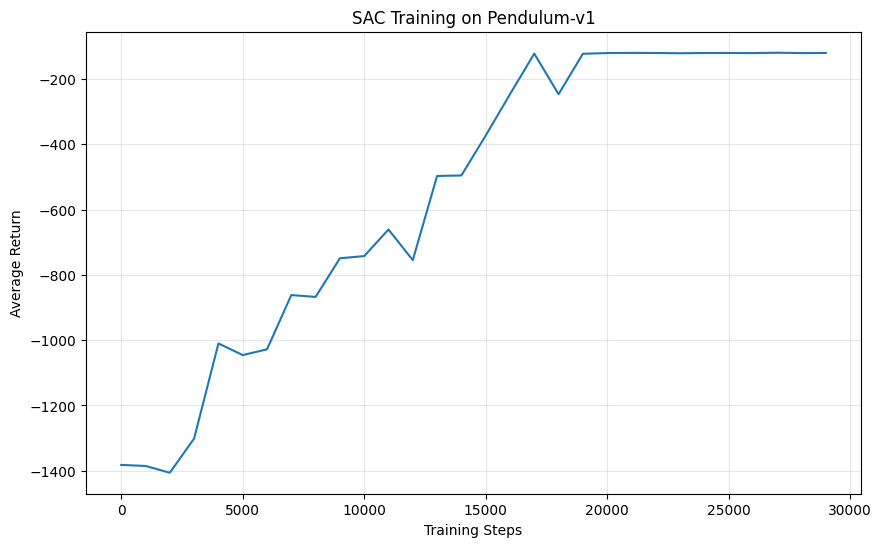

In [11]:
##### DO NOT CHANGE #####
def evaluate_policy(sac, n_episodes=5):
    """Evaluate policy without exploration"""
    eval_env = gym.make('Pendulum-v1')
    scores = []
    
    for _ in range(n_episodes):
        state, _ = eval_env.reset(seed=SEED)
        score = 0
        done = False
        
        while not done:
            with torch.no_grad():
                action, _ = sac.policy(torch.FloatTensor(state).unsqueeze(0), deterministic=True)
            scaled_action = action_max * action.item()
            state, reward, terminated, truncated, _ = eval_env.step([scaled_action])
            done = terminated or truncated
            score += reward
        
        scores.append(score)
    
    eval_env.close()
    return np.mean(scores)

# Training loop
sac = SoftActorCritic()

num_steps = 30000
eval_freq = 1000
reward_scale = 0.1

state, _ = env.reset(seed=SEED)
scores = []
steps = []

for step in range(num_steps):
    # Select action
    with torch.no_grad():
        action, _ = sac.policy(torch.FloatTensor(state).unsqueeze(0))
    scaled_action = action_max * action.item()
    
    # Environment step
    next_state, reward, terminated, truncated, _ = env.step([scaled_action])
    done = terminated or truncated
    
    # Store transition
    sac.memory.put((state, action.item(), reward * reward_scale, next_state, done))
    
    state = env.reset(seed=SEED)[0] if done else next_state
    
    # Train
    if sac.memory.size() > 1000:
        sac.train_step()
    
    # Evaluate
    if step % eval_freq == 0:
        score = evaluate_policy(sac)
        scores.append(score)
        steps.append(step)
        print(f"Step {step}, Score: {score:.2f}")

env.close()

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(steps, scores)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Average Return')
ax.set_title('SAC Training on Pendulum-v1')
ax.grid(True, alpha=0.3)
save_figure(fig, "sac_training")
plt.show()

##### DO NOT CHANGE #####

## Analysis

You should see the performance improve over time. SAC typically achieves near-optimal performance (scores around -150 to -200) after 20,000-30,000 steps.

Key observations:
- The entropy bonus encourages exploration early in training
- Twin Q-networks reduce overestimation bias
- Polyak updates provide stable learning

## Visualization

Let's visualize the learned value function by evaluating Q-values across the state space.

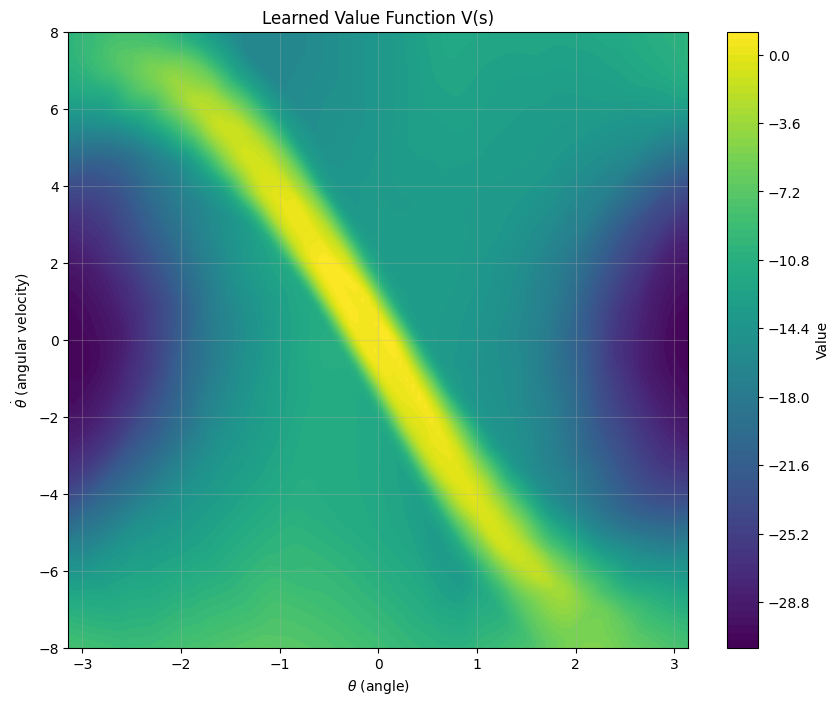

In [12]:
##### DO NOT CHANGE #####
def plot_value_function(sac, resolution=100):
    """Plot the value function by evaluating Q-values across the state space"""
    # Create grid of states
    max_speed = 8
    theta = np.linspace(-np.pi, np.pi, resolution)
    theta_dot = np.linspace(-max_speed, max_speed, resolution)
    
    # Create meshgrid for all state combinations
    theta_grid, theta_dot_grid = np.meshgrid(theta, theta_dot)
    
    # Convert to observations: (cos(theta), sin(theta), theta_dot)
    cos_theta = np.cos(theta_grid.flatten())
    sin_theta = np.sin(theta_grid.flatten())
    theta_dot_flat = theta_dot_grid.flatten()
    
    states = torch.tensor(np.stack([cos_theta, sin_theta, theta_dot_flat], axis=1), dtype=torch.float)
    
    # Evaluate value function by taking max over actions
    action_samples = np.linspace(-1, 1, 50)  # Sample actions in [-1, 1] range
    max_q_values = np.full(len(states), -np.inf)
    
    with torch.no_grad():
        for action_val in action_samples:
            actions = torch.full((len(states), 1), action_val, dtype=torch.float)
            q1 = sac.q_net_1(states, actions)
            q2 = sac.q_net_2(states, actions)
            min_q = torch.min(q1, q2).squeeze().numpy()
            max_q_values = np.maximum(max_q_values, min_q)
    
    # Reshape for plotting
    v_values = max_q_values.reshape(resolution, resolution)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(theta, theta_dot, v_values, levels=100, cmap='viridis')
    plt.colorbar(contour, ax=ax, label='Value')
    ax.set_xlabel(r'$\theta$ (angle)')
    ax.set_ylabel(r'$\dot{\theta}$ (angular velocity)')
    ax.set_title('Learned Value Function V(s)')
    ax.grid(True, alpha=0.3)
    save_figure(fig, "value_function")
    plt.show()

plot_value_function(sac)

##### DO NOT CHANGE #####

Let's watch how the agent perform

In [13]:
##### DO NOT CHANGE #####
def visualize_episode(sac, max_steps=200):
    """Visualize the agent performing in the environment"""
    eval_env = gym.make('Pendulum-v1', render_mode='rgb_array')
    
    state, _ = eval_env.reset(seed=SEED)
    frames = []
    total_reward = 0
    
    for step in range(max_steps):
        # Render current frame
        frame = eval_env.render()
        frames.append(frame)
        
        # Get action from policy
        with torch.no_grad():
            action, _ = sac.policy(torch.FloatTensor(state).unsqueeze(0), deterministic=True)
        scaled_action = action_max * action.item()
        
        # Step environment
        state, reward, terminated, truncated, _ = eval_env.step([scaled_action])
        total_reward += reward
        
        if terminated or truncated:
            break
    
    eval_env.close()
    
    # Create animation
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')
    img = ax.imshow(frames[0])
    
    def update(frame_idx):
        img.set_data(frames[frame_idx])
        ax.set_title(f'Step {frame_idx}/{len(frames)} | Total Reward: {total_reward:.1f}')
        return [img]
    
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    
    anim = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=True)
    plt.close()
    
    print(f"Episode completed in {len(frames)} steps with total reward: {total_reward:.2f}")
    return HTML(anim.to_jshtml())

# Visualize the trained policy
visualize_episode(sac)

##### DO NOT CHANGE #####

/home/mp/Documents/KIT/Reinforcement_Learning/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Episode completed in 200 steps with total reward: -119.91
